# "Cooperation Among Cancer Cells as Public Goods Games on Voronoi Networks"

#### This notebook reimpliments and explores the results given by Archetti in his paper on cooperation among cancer cells in voronoi networks.

## Structure of the Notebook

### Implimentation of the game

#### * Imports/Dependencies for the notebook
#### * Load graph file from observed cancer network + Label 5% as non-producers
#### * Displaying the graph 
#### * Defining Archetti's Payoff Functions
#### * Calculating Benefit based on Payoff Functions (I)
#### * Defining Update Rules
#### * Running the game with default parameters
______
#### * Defining and Explaining the "Parameter sheet"

### Replicating Archetti's results

#### 3.2 - Effect of costs and benefits
#### 3.3 - Effect of diffusion gradient
#### 3.4 - Peturbation of the inflection point

### Concluding Remarks





In [1]:
import numpy as np
from random import randint
import matplotlib as plt
import pylab as pl
import math
from matplotlib import collections  as mc
import scipy.sparse
import copy
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 10)

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['copy', 'plt', 'randint']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


#### Important Structures defined in this block:

* Interaction Graph: the set of one step neighbors defined by the voronoi tesselation on the cancer cell image

* Strategy Vector: the set of initial strategies for the vertices in the graph. We assign 5% to be non-producers (we do this to be consistant with Archetti

____

##### Notes on why other structures defined here are important:

* vertices - this array holds the positions in the image of each vertex in the graph. This will become important when we modify Archetti's results to check the discrepency between using voronoi tesslation and using observed distance.

* edge_list + edges - neither of these are incredibly important for the actual compuations happening here, but they do make displaying the graph with pylab much easier.

In [2]:
#===============================================================
#                   LOAD AND LABEL GRAPH
#===============================================================
interaction_graph = np.load("graph/interaction_graph.npy")
vertices = np.load("graph/vertex_list.npy")
edge_list = np.load("graph/edge_list.npy")
edges = np.load("graph/edges.npy")
#upgraded to 10% initial fraction to speed things up
non_producers_needed = int(0.05 * len(vertices))
strategy_vector = np.ones(len(vertices))
for i in range(non_producers_needed):
    strategy_vector[randint(len(vertices))] = 0
    
ORIGINAL_STRATEGY_VECTOR = np.copy(strategy_vector)

In [27]:
#===============================================================
#       CREATE DISTANCE GRAPH FROM INTERACTION GRAPH
#===============================================================
distance_graph = scipy.sparse.csgraph.floyd_warshall(interaction_graph, directed=False, 
                                                     return_predecessors=False, unweighted=True,
                                                     overwrite=False)


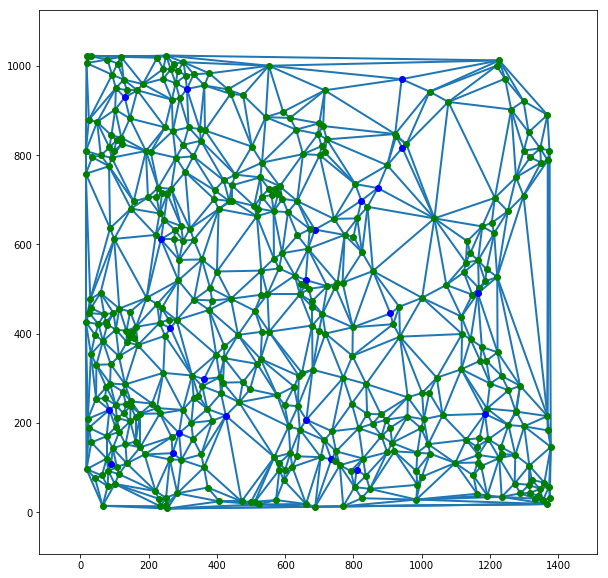

In [4]:
#===============================================================
#   DISPLAY GRAPH FUNCTION -> RELYS ON GLOBAL GRAPH STRUCTURE
#===============================================================
def display_graph(strategy_vector):
    edges = [[(vertices[i[0]][0], vertices[i[0]][1]), (vertices[i[1]][0], vertices[i[1]][1])] for i in edge_list]
    lc = mc.LineCollection(edges, linewidths=2)
    fig, ax = pl.subplots()
    ax.add_collection(lc)
    plt.ion()
    ind = 0
    for i in vertices:
        if(strategy_vector[ind] == 0):
            plt.plot(i[0],i[1],'bo')
        else:
            plt.plot(i[0],i[1],'go')
        ind+=1
    ax.autoscale()
    ax.margins(0.1) 
    plt.show()
    
display_graph(strategy_vector)

#### Check list of things needed for the game:

* Reproduction Graph -> Called 'interaction_graph' the reason that the interaction graph and the reproduction graph are the same in this implimentation is that the interaction graph only gives the one-step neighbors which is same as the focal group defined by archetti.


* Distance Graph -> Called the 'distance_graph,' we have run the floyd warshall (all pairs shortest path) algorithm on the interactino graph to get this matrix.


* Strategy vector -> Called 'strategy_vector' we got this by randomly assigning 5% of the cells in the graph to be non-producers as defined by Archetti.

________

#### What do we still need?

* Update rule - The rule that, given a cell, determines who will replace it given the reproduction graph.


* Diffusion gradient function - the function that determines exactly how much each cell in your area contributes to your fitness


* Benefit graph - not explicitly defined before this point, but this is the graph that we get from applying the diffusion gradient function to each component of the distance graph.

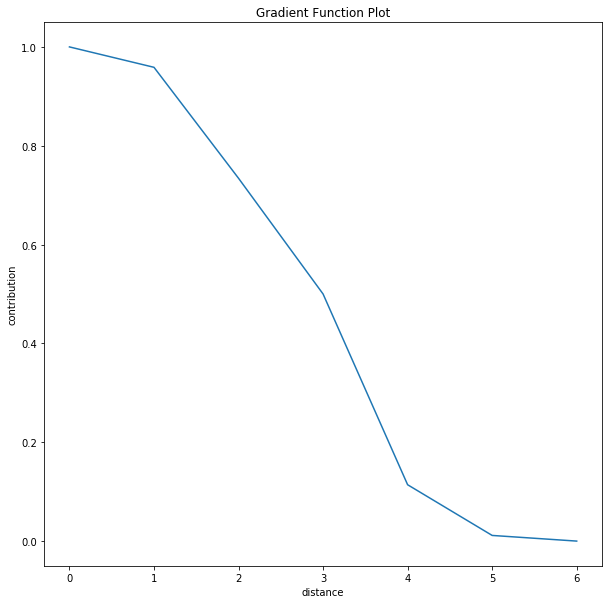

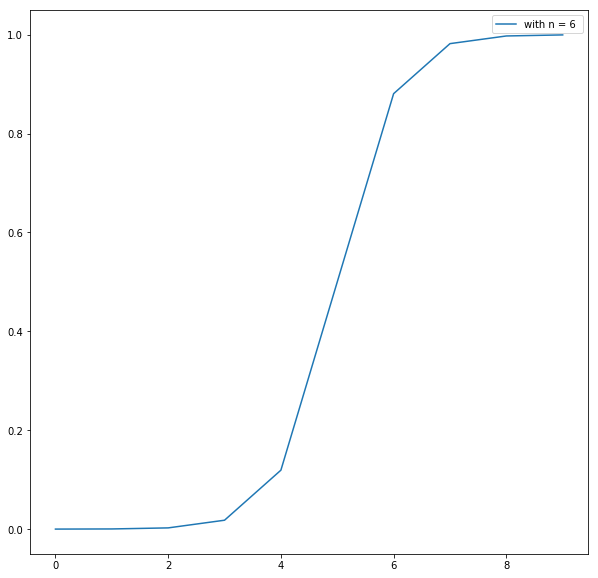

In [5]:
#===============================================================
#     DEFINE THE ARCHETTI CALCULATIONS FOR CELL BENEFIT G(i)
#===============================================================
#Params for the parameter sheet - this will be explained later
z_VALUE = 10
d_VALUE = 3
D_VALUE = 6
"""
g is the sigmoid helper function defined in Archetti.
i - distance in nodes from one vertex to the other
z - steepness of the inflection point of the function
d/D - Controls the shape of the function with d < D we get a sigmoid helper
"""
def g(i, z = z_VALUE, d = d_VALUE, D = D_VALUE):
    valA = (-z*(i-d))/D
    exp = math.exp(1)**valA
    return 1/(1 + exp)

"""
Gradient Function as defined in archetti

NB: The D parameter here should be the same as
the D parameter in the above function. That is
The non-zero scalar value in the denominator should be 
the same as D in the function g - no worries if using params_sheet
"""
def gradient_function(distance):
    return 1 - ((g(distance) - g(0)) / (g(D_VALUE) - g(0)))

#Lets try to observe the helper function shape:
value = []
for i in range(7):
    value.append(gradient_function(i))
plt.clf()
plt.title("Gradient Function Plot")
plt.xlabel("distance")
plt.ylabel("contribution")
plt.plot(value)
plt.show()

#THIS WILL NEED TO GO IN THE PARAMS SHEET
gf = np.vectorize(gradient_function)
s_VALUE = 20
k_VALUE = .5
n_VALUE =  1#6 * d_VALUE #number of people in the group * the cutoff
def v(j, s=s_VALUE, k = k_VALUE, n = n_VALUE):
    valA = (-s*(j-k))/n
    exp = math.exp(1)**valA
    return 1/(1 + exp) 

def payoff_function(i, strategy_vector):  
    n_array = feeling_graph[i]
    n = sum(n_array)
    j_array = np.multiply(n_array, strategy_vector)
    j = sum(j_array)
    #return (v(j,n)-v(0,n))/(v(n,n) - v(0,n)) <- This is how I think it should be done
    return (v(j)-v(0))/(v(n_VALUE) - v(0))

plt.clf()
values = []
handles = []


#Notice we only get a proper sigmoid when we have a
#large range (negative to positive) of values going in as j
#this should certainly not be the case, but I am not sure how 
#to fix it without changing archetti's formula's.
for j in range(0,10):
    jj = float(j)
    jj/=10
    values.append((v(jj)-v(0))/(v(n_VALUE)-v(0)))
title = "with n = %s "%(i)
handle, = plt.plot(values, label=title)
handles.append(handle)
values = []
plt.legend(handles=handles)
plt.show() 

#### Defining benefit funtions
##### Above, we establish Archetti's methods for calculating the contribution of a cell with respect to its distance. Previously, we calculated every cells  distance to one another, so here we can put some things together.

* COST_OF_PRODUCTION -> Each cooperator has to pay a cost to cooperate. This is the constant cost


* calculate_benefit -> calculates the benefit (without cost of production) for each cell in the graph


* adjusted_benefit -> calculated the benefit with calculate_benefit and then applys the cost of production

(451, 451)
<type 'numpy.ndarray'>


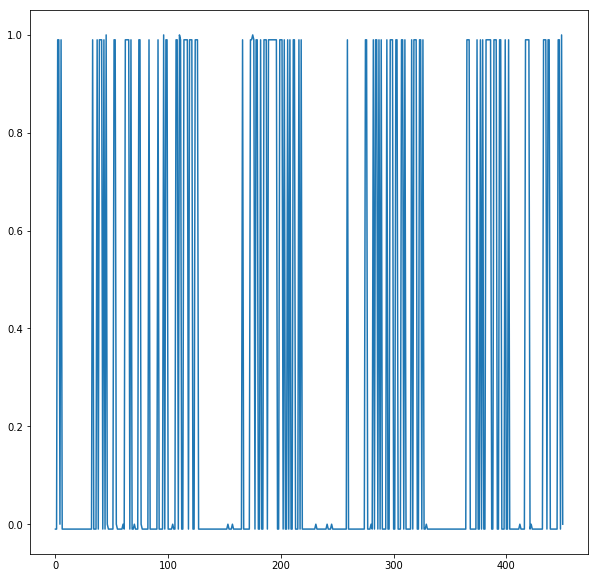

In [28]:
strategy_vector = strategy_vector.astype(float)

#Some more stuff to go in a params sheet
COST_OF_PRODUCTION = .01
CUTOFF = 3
distance_graph = np.asarray(distance_graph)
distance_graph.reshape(len(vertices), len(vertices))
print(distance_graph.shape)
print(type(distance_graph[0]))
distance_graph = [10 if i > CUTOFF else i for i in e for e in distance_graph]
distance_graph = np.asarray(distance_graph)
distance_graph = distance_graph.reshape(len(vertices), len(vertices))
distance_graph_two = [10 if i == 0 else i for i in e for e in distance_graph]
distance_graph = np.asarray(distance_graph_two)
distance_graph = distance_graph.reshape(len(vertices), len(vertices))
feeling_graph = gf(distance_graph)
#feeling_graph[feeling_graph == 1.0] = 0

def calculate_benefit():
    benefit_vector = []
    for i in range(len(vertices)):
        b = payoff_function(i, strategy_vector)
        benefit_vector.append(b)
    return benefit_vector

def adjusted_benefit():
    b = calculate_benefit()
    for i in range(len(vertices)):
        b[i] = b[i] - (COST_OF_PRODUCTION*strategy_vector[i])
    return b

b = adjusted_benefit()
plt.plot(b)
plt.show()

In [29]:
def conditional_imitation(strategy_vector, benefit_vector):
    update_number = randint(len(vertices))
    neighbors = np.nonzero(interaction_graph[update_number])
    updator = neighbors[0][randint(len(neighbors))]
    if(benefit_vector[update_number] >= benefit_vector[updator]):
        return 0
    else:
        strategy_vector[update_number] = strategy_vector[updator]
        return 1
        
def unconditional_imitation(strategy_vector, benefit_vector):
    update_number = randint(len(vertices))
    neighbors = np.nonzero(interaction_graph[update_number])
    updator = neighbors[0][randint(len(neighbors))]
    strategy_vector[update_number] = strategy_vector[updator]
    return 1

    
def stochastic_imitation(strategy_vector, benefit_vector):
    print("ERROR: Unimplimented Rule")

### The all-powerful parameters sheet

In several places above I have referenced a parameters sheet, and I continued to promise an explanation for why I am using one. Well, here is the explanation: 

In order to run Archetti's experiments, it seems a little crazy to re-initalize every portion of the code. After all, most things remain static. So, we have created a parameters sheet which will allow us to simply change the dynamic portions of the game. This includes logisitic payoff parameters (and the functions vectorized form) the distance graph (with respect to a cutoff, and the feeling graph with respect to a dynamic gradient function. 

TL;DR - Changing each of the dynamic values in the parameter sheet lets us easily run Archetti's results

In [32]:
#===================================================
#      PARAMETERS SHEET - SEE EXPLANATION BELOW
#===================================================
strategy_vector = np.copy(ORIGINAL_STRATEGY_VECTOR)
z_VALUE = 10
d_VALUE = 3
D_VALUE = 6
gf = np.vectorize(gradient_function)
s_VALUE = 20
k_VALUE = .5
n_VALUE =  1#6 * d_VALUE #number of people in the group * the cutoff
distance_graph = scipy.sparse.csgraph.floyd_warshall(interaction_graph, directed=False, 
                                                     return_predecessors=False, unweighted=True,
                                                     overwrite=False)
COST_OF_PRODUCTION = .01
CUTOFF = 3
# HERE WHAT WE DO IS WE SAY IF THE CELL IS DISTANCE GREATER THAN CUTOFF,
# THEN THE DISTANCE IS SET TO A LARGE VALUE TO PROHIBIT SUCH CELLS FROM CONTRIBUTING
# IF THE CELL IS 0 DISTANCE AWAY (ITSELF) WE DO THE SAME SO THAT IT CANNOT CONTRIBUTE
distance_graph = np.asarray(distance_graph)
distance_graph.reshape(len(vertices), len(vertices))
distance_graph = [10000 if i > CUTOFF else i for i in e for e in distance_graph]
distance_graph = np.asarray(distance_graph)
distance_graph = distance_graph.reshape(len(vertices), len(vertices))
distance_graph_two = [10000 if i == 0 else i for i in e for e in distance_graph]
distance_graph = np.asarray(distance_graph_two)
distance_graph = distance_graph.reshape(len(vertices), len(vertices))
feeling_graph = gf(distance_graph)

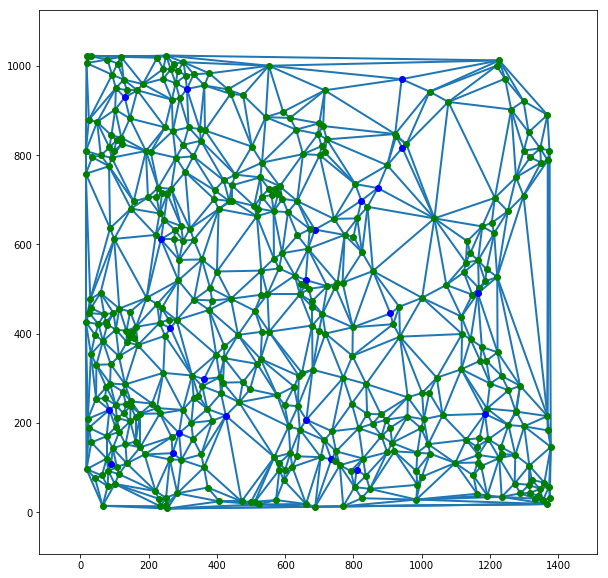

100%|██████████| 10000/10000 [01:29<00:00, 112.32it/s]


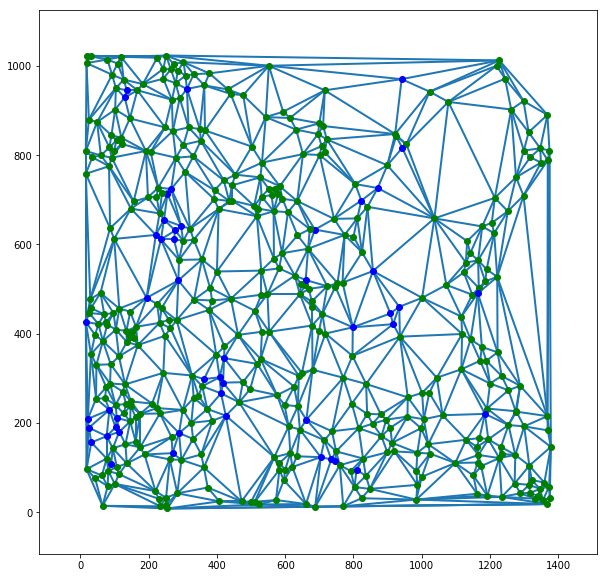

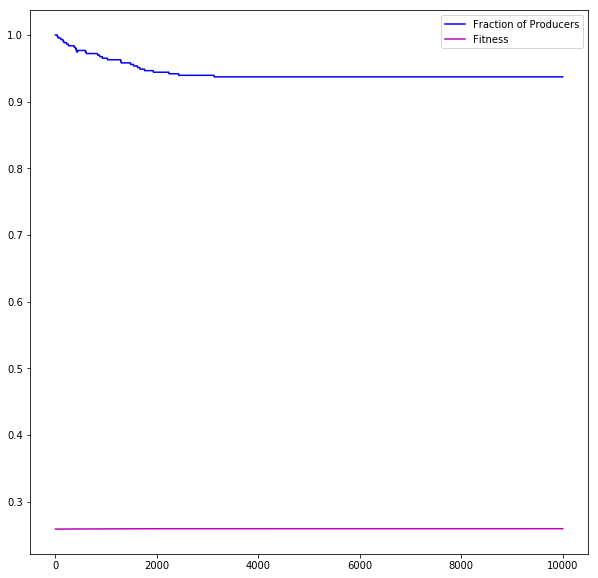

In [31]:
from tqdm import trange
#Global Structures:
# - interaction_graph
# - distance_graph
number_of_producers = []
fitness_of_system = []
benefit_vector = adjusted_benefit()
number_of_producers.append(len(np.nonzero(strategy_vector)[0]))
fitness_of_system.append(sum(benefit_vector)/len(vertices))
def play_game(strategy_vector, update_rule, iterations=10000):
    for i in trange(iterations):
        benefit_vector = adjusted_benefit()
        update_rule(strategy_vector, benefit_vector)
        number_of_producers.append(len(np.nonzero(strategy_vector)[0]))
        fitness_of_system.append(sum(benefit_vector)/len(vertices))
display_graph(strategy_vector)
play_game(strategy_vector, conditional_imitation)
display_graph(strategy_vector)

number_of_producers = np.asarray(number_of_producers)
number_of_producers= number_of_producers.astype(float)
number_of_producers /= np.max(number_of_producers)

plt.clf()
l1, = plt.plot(number_of_producers, label='Fraction of Producers', color='blue')
l2, = plt.plot(fitness_of_system, label='Fitness', color='m')
plt.legend(handles=[l1,l2])
plt.show()

### 3.2/3.4 - Effects of costs and benefits

#### Archetti claims that for higher values of c (cost of production) and for higher values of d (group size) that cooperation decreases. 

Here, we will observe the affect of costs of production and different inflection points on the benefit function. We will start with the focal group range at 2, and then will run the tests at 4 and 6.

We will progressively increase the cost first and plot the affect it has on the fraction of producers.

Next, we will look at the effects of the inflection point of the benefit function on the fraction of producers.

See Archetti in Fig 4.

**It seems Archetti is inconsistant with notation and h=k**

**We will be using a sigmoid diffusion gradient in this test**

In [33]:
def run_game_return_producers():
    number_of_producers = []
    benefit_vector = adjusted_benefit()
    number_of_producers.append(len(np.nonzero(strategy_vector)[0]))
    def play_game(strategy_vector, update_rule, iterations=3000):
        for i in trange(iterations):
            benefit_vector = adjusted_benefit()
            update_rule(strategy_vector, benefit_vector)
            number_of_producers.append(len(np.nonzero(strategy_vector)[0]))
    
    play_game(strategy_vector, conditional_imitation)
    
    
    number_of_producers = np.asarray(number_of_producers)
    number_of_producers= number_of_producers.astype(float)
    number_of_producers /= np.max(number_of_producers)
    return number_of_producers

100%|██████████| 3000/3000 [00:24<00:00, 122.34it/s]


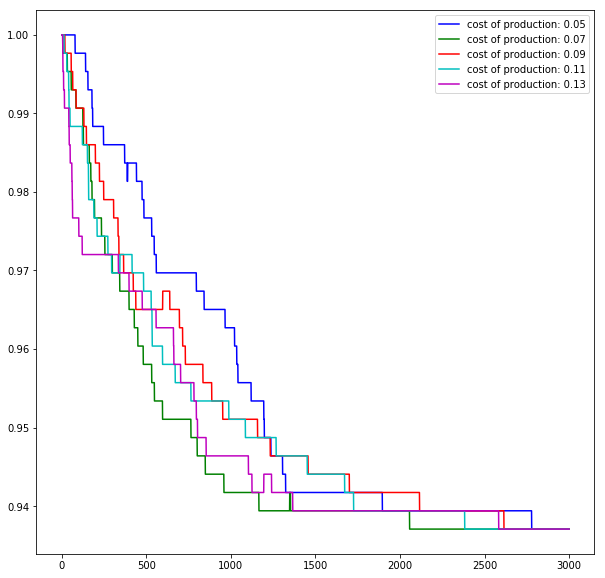

In [34]:
#===================================================
#      PARAMETERS SHEET - Sigmoid Diffusion Gradient
#===================================================
strategy_vector = np.copy(ORIGINAL_STRATEGY_VECTOR)
z_VALUE = 10
d_VALUE = 2
D_VALUE = 6
def g(i, z = z_VALUE, d = d_VALUE, D = D_VALUE):
    valA = (-z*(i-d))/D
    exp = math.exp(1)**valA
    return 1/(1 + exp)
gf = np.vectorize(gradient_function)
s_VALUE = 20
k_VALUE = .5
n_VALUE =  1#6 * d_VALUE #number of people in the group * the cutoff
distance_graph = scipy.sparse.csgraph.floyd_warshall(interaction_graph, directed=False, 
                                                     return_predecessors=False, unweighted=True,
                                                     overwrite=False)
CUTOFF = 2
COST_OF_PRODUCTION = .05
# HERE WHAT WE DO IS WE SAY IF THE CELL IS DISTANCE GREATER THAN CUTOFF,
# THEN THE DISTANCE IS SET TO A LARGE VALUE TO PROHIBIT SUCH CELLS FROM CONTRIBUTING
# IF THE CELL IS 0 DISTANCE AWAY (ITSELF) WE DO THE SAME SO THAT IT CANNOT CONTRIBUTE
distance_graph = np.asarray(distance_graph)
distance_graph.reshape(len(vertices), len(vertices))
distance_graph = [10000 if i > CUTOFF else i for i in e for e in distance_graph]
distance_graph = np.asarray(distance_graph)
distance_graph = distance_graph.reshape(len(vertices), len(vertices))
distance_graph_two = [10000 if i == 0 else i for i in e for e in distance_graph]
distance_graph = np.asarray(distance_graph_two)
distance_graph = distance_graph.reshape(len(vertices), len(vertices))
feeling_graph = gf(distance_graph)

colors =['b', 'g', 'r', 'c', 'm']
producers = []
handles = []
for i in range(5):
    strategy_vector = np.copy(ORIGINAL_STRATEGY_VECTOR)
    l = "cost of production: %s"%(COST_OF_PRODUCTION)
    handle, = plt.plot(run_game_return_producers(), color=colors[i], label=l)
    handles.append(handle)
    COST_OF_PRODUCTION+=.02
plt.legend(handles=handles)
plt.show()  

#These results clearly make no sense. 

In [ ]:
#===================================================
#      PARAMETERS SHEET - Sigmoid Diffusion Gradient
#===================================================
strategy_vector = np.copy(ORIGINAL_STRATEGY_VECTOR)
z_VALUE = 10
d_VALUE = 4
D_VALUE = 6
def g(i, z = z_VALUE, d = d_VALUE, D = D_VALUE):
    valA = (-z*(i-d))/D
    exp = math.exp(1)**valA
    return 1/(1 + exp)
gf = np.vectorize(gradient_function)
s_VALUE = 20
k_VALUE = .5
n_VALUE =  1#6 * d_VALUE #number of people in the group * the cutoff
distance_graph = scipy.sparse.csgraph.floyd_warshall(interaction_graph, directed=False, 
                                                     return_predecessors=False, unweighted=True,
                                                     overwrite=False)
CUTOFF = 4
COST_OF_PRODUCTION = .05
# HERE WHAT WE DO IS WE SAY IF THE CELL IS DISTANCE GREATER THAN CUTOFF,
# THEN THE DISTANCE IS SET TO A LARGE VALUE TO PROHIBIT SUCH CELLS FROM CONTRIBUTING
# IF THE CELL IS 0 DISTANCE AWAY (ITSELF) WE DO THE SAME SO THAT IT CANNOT CONTRIBUTE
distance_graph = np.asarray(distance_graph)
distance_graph.reshape(len(vertices), len(vertices))
distance_graph = [10000 if i > CUTOFF else i for i in e for e in distance_graph]
distance_graph = np.asarray(distance_graph)
distance_graph = distance_graph.reshape(len(vertices), len(vertices))
distance_graph_two = [10000 if i == 0 else i for i in e for e in distance_graph]
distance_graph = np.asarray(distance_graph_two)
distance_graph = distance_graph.reshape(len(vertices), len(vertices))
feeling_graph = gf(distance_graph)

colors =['b', 'g', 'r', 'c', 'm']
producers = []
handles = []
for i in range(5):
    strategy_vector = np.copy(ORIGINAL_STRATEGY_VECTOR)
    l = "cost of production: %s"%(COST_OF_PRODUCTION)
    handle, = plt.plot(run_game_return_producers(), color=colors[i], label=l)
    handles.append(handle)
    COST_OF_PRODUCTION+=.02
plt.legend(handles=handles)
plt.show()  


In [ ]:
#===================================================
#      PARAMETERS SHEET - Sigmoid Diffusion Gradient
#===================================================
strategy_vector = np.copy(ORIGINAL_STRATEGY_VECTOR)
z_VALUE = 10
d_VALUE = 6
D_VALUE = 6
def g(i, z = z_VALUE, d = d_VALUE, D = D_VALUE):
    valA = (-z*(i-d))/D
    exp = math.exp(1)**valA
    return 1/(1 + exp)
gf = np.vectorize(gradient_function)
s_VALUE = 20
k_VALUE = .5
n_VALUE =  1#6 * d_VALUE #number of people in the group * the cutoff
distance_graph = scipy.sparse.csgraph.floyd_warshall(interaction_graph, directed=False, 
                                                     return_predecessors=False, unweighted=True,
                                                     overwrite=False)
CUTOFF = 6
COST_OF_PRODUCTION = .05
# HERE WHAT WE DO IS WE SAY IF THE CELL IS DISTANCE GREATER THAN CUTOFF,
# THEN THE DISTANCE IS SET TO A LARGE VALUE TO PROHIBIT SUCH CELLS FROM CONTRIBUTING
# IF THE CELL IS 0 DISTANCE AWAY (ITSELF) WE DO THE SAME SO THAT IT CANNOT CONTRIBUTE
distance_graph = np.asarray(distance_graph)
distance_graph.reshape(len(vertices), len(vertices))
distance_graph = [10000 if i > CUTOFF else i for i in e for e in distance_graph]
distance_graph = np.asarray(distance_graph)
distance_graph = distance_graph.reshape(len(vertices), len(vertices))
distance_graph_two = [10000 if i == 0 else i for i in e for e in distance_graph]
distance_graph = np.asarray(distance_graph_two)
distance_graph = distance_graph.reshape(len(vertices), len(vertices))
feeling_graph = gf(distance_graph)

colors =['b', 'g', 'r', 'c', 'm']
producers = []
handles = []
for i in range(5):
    strategy_vector = np.copy(ORIGINAL_STRATEGY_VECTOR)
    l = "cost of production: %s"%(COST_OF_PRODUCTION)
    handle, = plt.plot(run_game_return_producers(), color=colors[i], label=l)
    handles.append(handle)
    COST_OF_PRODUCTION+=.02
plt.legend(handles=handles)
plt.show()  


In [ ]:
#===================================================
#      PARAMETERS SHEET - Sigmoid Diffusion Gradient
#===================================================
strategy_vector = np.copy(ORIGINAL_STRATEGY_VECTOR)
z_VALUE = 10
d_VALUE = 2
D_VALUE = 6
def g(i, z = z_VALUE, d = d_VALUE, D = D_VALUE):
    valA = (-z*(i-d))/D
    exp = math.exp(1)**valA
    return 1/(1 + exp)
gf = np.vectorize(gradient_function)
s_VALUE = 20
k_VALUE = .5
n_VALUE =  1#6 * d_VALUE #number of people in the group * the cutoff
distance_graph = scipy.sparse.csgraph.floyd_warshall(interaction_graph, directed=False, 
                                                     return_predecessors=False, unweighted=True,
                                                     overwrite=False)
CUTOFF = 2
COST_OF_PRODUCTION = .05
# HERE WHAT WE DO IS WE SAY IF THE CELL IS DISTANCE GREATER THAN CUTOFF,
# THEN THE DISTANCE IS SET TO A LARGE VALUE TO PROHIBIT SUCH CELLS FROM CONTRIBUTING
# IF THE CELL IS 0 DISTANCE AWAY (ITSELF) WE DO THE SAME SO THAT IT CANNOT CONTRIBUTE
distance_graph = np.asarray(distance_graph)
distance_graph.reshape(len(vertices), len(vertices))
distance_graph = [10000 if i > CUTOFF else i for i in e for e in distance_graph]
distance_graph = np.asarray(distance_graph)
distance_graph = distance_graph.reshape(len(vertices), len(vertices))
distance_graph_two = [10000 if i == 0 else i for i in e for e in distance_graph]
distance_graph = np.asarray(distance_graph_two)
distance_graph = distance_graph.reshape(len(vertices), len(vertices))
feeling_graph = gf(distance_graph)

producers = []
handles = []
for i in range(8):
    strategy_vector = np.copy(ORIGINAL_STRATEGY_VECTOR)
    l = "inflection of b(i): %s"%(k_VALUE)
    handle, = plt.plot(run_game_return_producers(), label=l)
    handles.append(handle)
    k_VALUE += .1
plt.legend(handles=handles)
plt.show() 

In [ ]:
#===================================================
#      PARAMETERS SHEET - Sigmoid Diffusion Gradient
#===================================================
strategy_vector = np.copy(ORIGINAL_STRATEGY_VECTOR)
z_VALUE = 10
d_VALUE = 4
D_VALUE = 6
def g(i, z = z_VALUE, d = d_VALUE, D = D_VALUE):
    valA = (-z*(i-d))/D
    exp = math.exp(1)**valA
    return 1/(1 + exp)
gf = np.vectorize(gradient_function)
s_VALUE = 20
k_VALUE = .5
n_VALUE =  1#6 * d_VALUE #number of people in the group * the cutoff
distance_graph = scipy.sparse.csgraph.floyd_warshall(interaction_graph, directed=False, 
                                                     return_predecessors=False, unweighted=True,
                                                     overwrite=False)
CUTOFF = 4
COST_OF_PRODUCTION = .05
# HERE WHAT WE DO IS WE SAY IF THE CELL IS DISTANCE GREATER THAN CUTOFF,
# THEN THE DISTANCE IS SET TO A LARGE VALUE TO PROHIBIT SUCH CELLS FROM CONTRIBUTING
# IF THE CELL IS 0 DISTANCE AWAY (ITSELF) WE DO THE SAME SO THAT IT CANNOT CONTRIBUTE
distance_graph = np.asarray(distance_graph)
distance_graph.reshape(len(vertices), len(vertices))
distance_graph = [10000 if i > CUTOFF else i for i in e for e in distance_graph]
distance_graph = np.asarray(distance_graph)
distance_graph = distance_graph.reshape(len(vertices), len(vertices))
distance_graph_two = [10000 if i == 0 else i for i in e for e in distance_graph]
distance_graph = np.asarray(distance_graph_two)
distance_graph = distance_graph.reshape(len(vertices), len(vertices))
feeling_graph = gf(distance_graph)

producers = []
handles = []
for i in range(8):
    strategy_vector = np.copy(ORIGINAL_STRATEGY_VECTOR)
    l = "inflection of b(i): %s"%(k_VALUE)
    handle, = plt.plot(run_game_return_producers(), label=l)
    handles.append(handle)
    k_VALUE += .1
plt.legend(handles=handles)
plt.show() 

In [ ]:
#===================================================
#      PARAMETERS SHEET - Sigmoid Diffusion Gradient
#===================================================
strategy_vector = np.copy(ORIGINAL_STRATEGY_VECTOR)
z_VALUE = 10
d_VALUE = 6
D_VALUE = 6
def g(i, z = z_VALUE, d = d_VALUE, D = D_VALUE):
    valA = (-z*(i-d))/D
    exp = math.exp(1)**valA
    return 1/(1 + exp)
gf = np.vectorize(gradient_function)
s_VALUE = 20
k_VALUE = .5
n_VALUE =  1#6 * d_VALUE #number of people in the group * the cutoff
distance_graph = scipy.sparse.csgraph.floyd_warshall(interaction_graph, directed=False, 
                                                     return_predecessors=False, unweighted=True,
                                                     overwrite=False)
CUTOFF = 6
COST_OF_PRODUCTION = .05
# HERE WHAT WE DO IS WE SAY IF THE CELL IS DISTANCE GREATER THAN CUTOFF,
# THEN THE DISTANCE IS SET TO A LARGE VALUE TO PROHIBIT SUCH CELLS FROM CONTRIBUTING
# IF THE CELL IS 0 DISTANCE AWAY (ITSELF) WE DO THE SAME SO THAT IT CANNOT CONTRIBUTE
distance_graph = np.asarray(distance_graph)
distance_graph.reshape(len(vertices), len(vertices))
distance_graph = [10000 if i > CUTOFF else i for i in e for e in distance_graph]
distance_graph = np.asarray(distance_graph)
distance_graph = distance_graph.reshape(len(vertices), len(vertices))
distance_graph_two = [10000 if i == 0 else i for i in e for e in distance_graph]
distance_graph = np.asarray(distance_graph_two)
distance_graph = distance_graph.reshape(len(vertices), len(vertices))
feeling_graph = gf(distance_graph)

producers = []
handles = []
for i in range(8):
    strategy_vector = np.copy(ORIGINAL_STRATEGY_VECTOR)
    l = "inflection of b(i): %s"%(k_VALUE)
    handle, = plt.plot(run_game_return_producers(), label=l)
    handles.append(handle)
    k_VALUE += .1
plt.legend(handles=handles)
plt.show() 

### 3.3 - Effects of diffusion gradients

We will try to replicate each of the values given by Archetti in Fig 7. :

*"(a) Fixed diffusion range with no diffusion gradient (d=3, D=6, z=1000). (b) Sigmoid diffusion gradient (d=3, D=6, z=10). (c) Linear diffusion gradient (d=3, D=6, z=1). (d) Concave diffusion gradient (d=0, D=7, z=3)."*

In [35]:
def run_game_with_output():
    number_of_producers = []
    fitness_of_system = []
    benefit_vector = adjusted_benefit()
    number_of_producers.append(len(np.nonzero(strategy_vector)[0]))
    fitness_of_system.append(sum(benefit_vector)/len(vertices))
    def play_game(strategy_vector, update_rule, iterations=3000):
        for i in trange(iterations):
            benefit_vector = adjusted_benefit()
            update_rule(strategy_vector, benefit_vector)
            number_of_producers.append(len(np.nonzero(strategy_vector)[0]))
            fitness_of_system.append(sum(benefit_vector)/len(vertices))
    play_game(strategy_vector, conditional_imitation)
    display_graph(strategy_vector)
    
    number_of_producers = np.asarray(number_of_producers)
    number_of_producers= number_of_producers.astype(float)
    number_of_producers /= np.max(number_of_producers)

    plt.clf()
    l1, = plt.plot(number_of_producers, label='Fraction of Producers', color='blue')
    l2, = plt.plot(fitness_of_system, label='Fitness', color='m')
    plt.legend(handles=[l1,l2])
    plt.show()

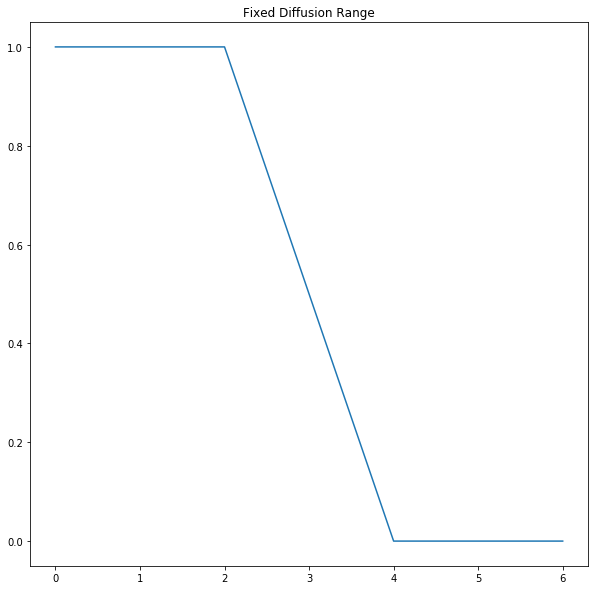

100%|██████████| 3000/3000 [00:26<00:00, 114.85it/s]


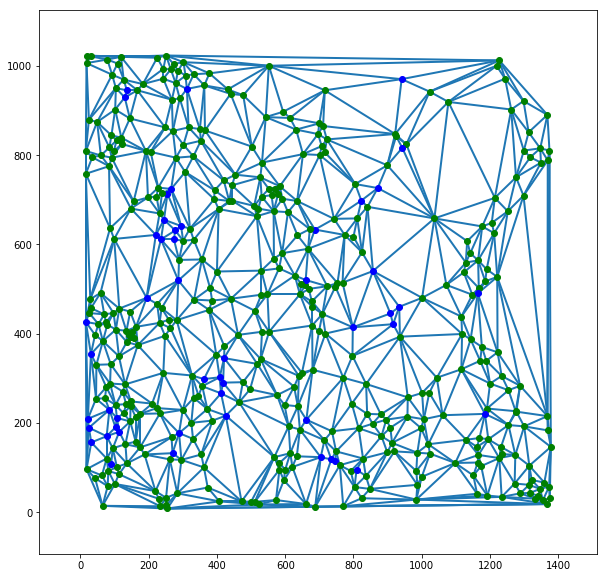

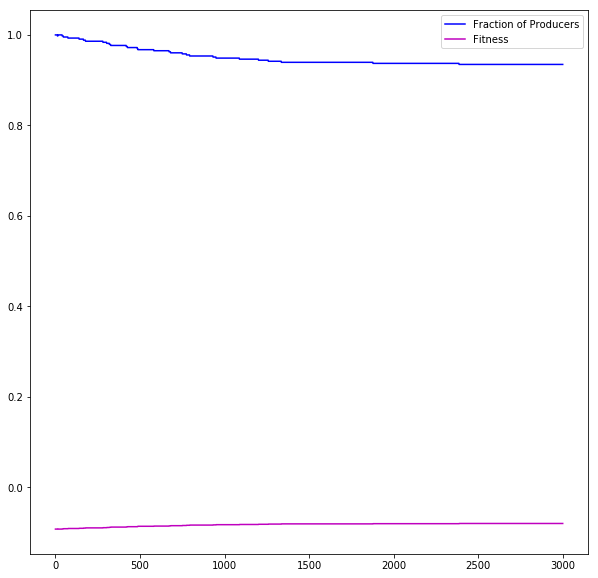

In [ ]:
#===================================================
#      PARAMETERS SHEET - No Diffusion Gradient
#===================================================
strategy_vector = np.copy(ORIGINAL_STRATEGY_VECTOR)
z_VALUE = 1000
d_VALUE = 3
D_VALUE = 6
def g(i, z = z_VALUE, d = d_VALUE, D = D_VALUE):
    valA = (-z*(i-d))/D
    exp = math.exp(1)**valA
    return 1/(1 + exp)
gf = np.vectorize(gradient_function)
s_VALUE = 20
k_VALUE = .1
distance_graph = scipy.sparse.csgraph.floyd_warshall(interaction_graph, directed=False, 
                                                     return_predecessors=False, unweighted=True,
                                                     overwrite=False)
CUTOFF = 6
COST_OF_PRODUCTION = .2
# HERE WHAT WE DO IS WE SAY IF THE CELL IS DISTANCE GREATER THAN CUTOFF,
# THEN THE DISTANCE IS SET TO A LARGE VALUE TO PROHIBIT SUCH CELLS FROM CONTRIBUTING
# IF THE CELL IS 0 DISTANCE AWAY (ITSELF) WE DO THE SAME SO THAT IT CANNOT CONTRIBUTE
distance_graph = np.asarray(distance_graph)
distance_graph.reshape(len(vertices), len(vertices))
distance_graph = [10000 if i > CUTOFF else i for i in e for e in distance_graph]
distance_graph = np.asarray(distance_graph)
distance_graph = distance_graph.reshape(len(vertices), len(vertices))
distance_graph_two = [10000 if i == 0 else i for i in e for e in distance_graph]
distance_graph = np.asarray(distance_graph_two)
distance_graph = distance_graph.reshape(len(vertices), len(vertices))
feeling_graph = gf(distance_graph)

value = []
for i in range(7):
    value.append(gf(i))
plt.clf()
plt.plot(value)
plt.title("Fixed Diffusion Range")
plt.show()
run_game_with_output()

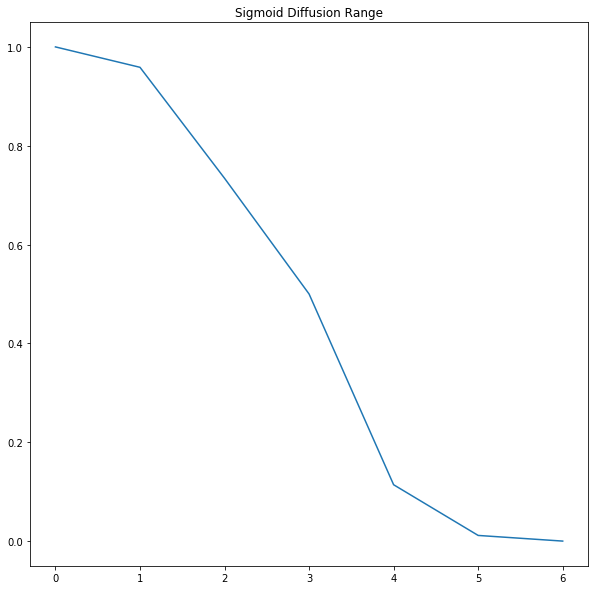

 61%|██████    | 1835/3000 [00:15<00:09, 121.91it/s]

In [ ]:
#===================================================
#      PARAMETERS SHEET - Sigmoid Diffusion Gradient
#===================================================
strategy_vector = np.copy(ORIGINAL_STRATEGY_VECTOR)
z_VALUE = 10
d_VALUE = 3
D_VALUE = 6
def g(i, z = z_VALUE, d = d_VALUE, D = D_VALUE):
    valA = (-z*(i-d))/D
    exp = math.exp(1)**valA
    return 1/(1 + exp)
gf = np.vectorize(gradient_function)
s_VALUE = 20
k_VALUE = .1
distance_graph = scipy.sparse.csgraph.floyd_warshall(interaction_graph, directed=False, 
                                                     return_predecessors=False, unweighted=True,
                                                     overwrite=False)
CUTOFF = 6
COST_OF_PRODUCTION = .2
# HERE WHAT WE DO IS WE SAY IF THE CELL IS DISTANCE GREATER THAN CUTOFF,
# THEN THE DISTANCE IS SET TO A LARGE VALUE TO PROHIBIT SUCH CELLS FROM CONTRIBUTING
# IF THE CELL IS 0 DISTANCE AWAY (ITSELF) WE DO THE SAME SO THAT IT CANNOT CONTRIBUTE
distance_graph = np.asarray(distance_graph)
distance_graph.reshape(len(vertices), len(vertices))
distance_graph = [10000 if i > CUTOFF else i for i in e for e in distance_graph]
distance_graph = np.asarray(distance_graph)
distance_graph = distance_graph.reshape(len(vertices), len(vertices))
distance_graph_two = [10000 if i == 0 else i for i in e for e in distance_graph]
distance_graph = np.asarray(distance_graph_two)
distance_graph = distance_graph.reshape(len(vertices), len(vertices))
feeling_graph = gf(distance_graph)

value = []
for i in range(7):
    value.append(gf(i))
plt.clf()
plt.plot(value)
plt.title("Sigmoid Diffusion Range")
plt.show()
run_game_with_output()

In [ ]:
#===================================================
#      PARAMETERS SHEET - Linear Diffusion Gradient
#===================================================
strategy_vector = np.copy(ORIGINAL_STRATEGY_VECTOR)
z_VALUE = .1
d_VALUE = 3
D_VALUE = 6
def g(i, z = z_VALUE, d = d_VALUE, D = D_VALUE):
    valA = (-z*(i-d))/D
    exp = math.exp(1)**valA
    return 1/(1 + exp)
gf = np.vectorize(gradient_function)
s_VALUE = 20
k_VALUE = .1
distance_graph = scipy.sparse.csgraph.floyd_warshall(interaction_graph, directed=False, 
                                                     return_predecessors=False, unweighted=True,
                                                     overwrite=False)
CUTOFF = 6
COST_OF_PRODUCTION = .2
# HERE WHAT WE DO IS WE SAY IF THE CELL IS DISTANCE GREATER THAN CUTOFF,
# THEN THE DISTANCE IS SET TO A LARGE VALUE TO PROHIBIT SUCH CELLS FROM CONTRIBUTING
# IF THE CELL IS 0 DISTANCE AWAY (ITSELF) WE DO THE SAME SO THAT IT CANNOT CONTRIBUTE
distance_graph = np.asarray(distance_graph)
distance_graph.reshape(len(vertices), len(vertices))
distance_graph = [10000 if i > CUTOFF else i for i in e for e in distance_graph]
distance_graph = np.asarray(distance_graph)
distance_graph = distance_graph.reshape(len(vertices), len(vertices))
distance_graph_two = [10000 if i == 0 else i for i in e for e in distance_graph]
distance_graph = np.asarray(distance_graph_two)
distance_graph = distance_graph.reshape(len(vertices), len(vertices))
feeling_graph = gf(distance_graph)

value = []
for i in range(7):
    value.append(gf(i))
plt.clf()
plt.plot(value)
plt.title("Linear Diffusion Range")
plt.show()
run_game_with_output()

In [ ]:
#===================================================
#      PARAMETERS SHEET - Concave Diffusion Gradient
#===================================================
strategy_vector = np.copy(ORIGINAL_STRATEGY_VECTOR)
z_VALUE = 7
d_VALUE = 0
D_VALUE = 7
def g(i, z = z_VALUE, d = d_VALUE, D = D_VALUE):
    valA = (-z*(i-d))/D
    exp = math.exp(1)**valA
    return 1/(1 + exp)
gf = np.vectorize(gradient_function)
s_VALUE = 20
k_VALUE = .1
distance_graph = scipy.sparse.csgraph.floyd_warshall(interaction_graph, directed=False, 
                                                     return_predecessors=False, unweighted=True,
                                                     overwrite=False)
CUTOFF = 6
COST_OF_PRODUCTION = .2
# HERE WHAT WE DO IS WE SAY IF THE CELL IS DISTANCE GREATER THAN CUTOFF,
# THEN THE DISTANCE IS SET TO A LARGE VALUE TO PROHIBIT SUCH CELLS FROM CONTRIBUTING
# IF THE CELL IS 0 DISTANCE AWAY (ITSELF) WE DO THE SAME SO THAT IT CANNOT CONTRIBUTE
distance_graph = np.asarray(distance_graph)
distance_graph.reshape(len(vertices), len(vertices))
distance_graph = [10000 if i > CUTOFF else i for i in e for e in distance_graph]
distance_graph = np.asarray(distance_graph)
distance_graph = distance_graph.reshape(len(vertices), len(vertices))
distance_graph_two = [10000 if i == 0 else i for i in e for e in distance_graph]
distance_graph = np.asarray(distance_graph_two)
distance_graph = distance_graph.reshape(len(vertices), len(vertices))
feeling_graph = gf(distance_graph)

value = []
for i in range(7):
    value.append(gf(i))
plt.clf()
plt.plot(value)
plt.title("Concave Diffusion Range")
plt.show()
run_game_with_output()